In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import Slider, RangeSlider, Button

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from random import sample

In [3]:
#adding a custom google font that is used by brand
from matplotlib import font_manager
from matplotlib import rcParams
path = 'Stoke.ttf'
font_manager.fontManager.addfont(path)

#ensure that it was added
font_manager.findfont("Stoke")
#setting font to all text on plots
rcParams['font.family'] = "Stoke"

# Retention/churn rates

Retention will be measured using monthly cohorts; each cohort will be all users who joined in the same month. We will also break these out into 3 different categories: VIPs, basic or base subscribers, and upgraded subscribers. The upgraded category is mostly to keep the other two honest/clean as leaving them in would introduce a fair bit of bias and would skew the data.

It's important that we use monthly cohorts otherwise we risk having a KPI that is totally false. For example skewing data based on just looking at "who is still active" vs "what percentage are still active". Or worse comparing total subscriber numbers from X months ago to total subscribers today and taking the difference to be "retention". As obviously and stupidely wrong as both of those seem, I have seen numerous KPI and data SaaS services make those exact mistakes and others.

### Importing and cleaning data

In [4]:
#This data is for identifying 3 types of customers: 
#base subscriber, VIP subscribers, and base subscribers that upgraded to VIP
customer_type = pd.read_csv('All-Orders-Clean.csv')
customer_type.columns = customer_type.columns.str.lower()
customer_type.rename(columns={"customer user id": "user id"}, inplace=True)
cols = ['user id', 'order id', 'product name', 'order date']
customer_type['order date'] = pd.to_datetime(customer_type['order date'])
customer_type = customer_type[cols]
print(customer_type['product name'].unique())

print('number of NaN orders:', len(customer_type.loc[customer_type['product name'].isna()])) #there are 42, will drop them
customer_type = customer_type.loc[~customer_type['product name'].isna()]
customer_type.reset_index(inplace=True, drop=True)
#print('all orders df;', len(customer_type))

#grabbing all VIPS (including those that upgraded)
first_vip = dt.datetime(2019, 10, 1) #no one before this date could possibly be a VIP
all_vips_list = list(customer_type.loc[((customer_type['product name'].str.contains("vip", case=False))&(customer_type['order date']>first_vip)), 'user id'].unique())
print('total VIPs (both upgraded and pure):', len(all_vips_list))

#grabbing VIPs that upgraded from a base subscription
all_vips_df = customer_type.loc[customer_type['user id'].isin(all_vips_list)]
#print('all VIPs df:', len(all_vips_df))
#before we can filter for base items, we need to limit it to subscription items; 
#VIPs can buy handles, soap, brushes, and other non VIP exclusives, but that doesn't mean they had a base subscription
subscriptions_only = all_vips_df.loc[all_vips_df['product name'].str.contains("month", case=False)]
#now use ~ to inverse filter on word VIP
upgraded_vip_list = list(subscriptions_only.loc[~subscriptions_only['product name'].str.contains("vip", case=False), 'user id'].unique())
print('number of upgraded VIPs:', len(upgraded_vip_list))

#now filtering all VIPs to only include those who were never base subscribers
pure_vip_list = [user for user in all_vips_list if user not in upgraded_vip_list]
print('number of pure upgraded VIPs:', len(pure_vip_list))

['The 5 Bladed Colonel - Every 2 months'
 'The 5 Bladed Colonel - Each month'
 'The 5 Bladed Colonel - Every 3 months' 'New Starter Handle'
 'Blade (Single)' 'Starter Handle' 'swcrd' 'Sandalwood Shaving Cream'
 'Blue Travel Cover' 'Badger Shaving Brush' "The Colonel's Sidekick"
 'Sensitive Shaving Cream' 'Brush with Sensitive Cream (combo)'
 'The Five Bladed Colonel - Every 2 months'
 'The Five Bladed Colonel - Each month'
 'The Five Bladed Colonel - Every 3 months' nan 'Tin (empty)'
 'Brush with Sandalwood Cream (combo)' 'VIP Membership - Each month'
 'VIP Starter Set' 'The Gift Set - Sensitive'
 'VIP Membership - Every 3 months' "King's Gambit Beard Oil"
 'Starter Handle (retired)' 'VIP Membership - Every 2 months'
 'Premium Handle' 'Upgrade To VIP - Each month'
 '5 Bladed Colonel - Each month' 'VIP Refill 4 Pack'
 'Claim Premium Handle' 'Leather Wash Bag'
 'VIP Upgrade (Refill On Demand)' '5 Bladed Colonel' 'VIP Membership'
 '5 Bladed Colonel - Every 2 months' 'The 5 Bladed Colonel'

In [5]:
customer_type.head(2)

,user id,order id,product name,order date
0,1303596,591726,The 5 Bladed Colonel - Every 2 months,2019-10-01 00:00:03
1,1304065,591729,The 5 Bladed Colonel - Every 2 months,2019-10-01 00:01:02


In [6]:
#importing coupon data - captures useful demographic data
#will be used downstream for ML predictions
coupons = pd.read_csv('All-Orders-Coupons.csv')
coupons.columns = coupons.columns.str.lower()
coupons.rename(columns={"coupons used": "coupon"}, inplace=True)
coupons.head(2)

,customer user id,order id,coupon
0,1283450,1769,swigshave
1,1283452,1775,swigshave


In [7]:
#importing all the different orders
orders = pd.read_csv('All-Completed-Lifetime.csv')
orders.columns = orders.columns.str.lower()
orders.rename(columns={"customer user id": "user id"}, inplace=True)
#next line, breaks dates into 1 month periods; cleans data and much easier for boolean masking
orders['order date'] = pd.to_datetime(orders['order date']).dt.to_period("M")

orders.drop(columns=['order currency', 'billing email address'], inplace=True)

print(len(orders))
orders.drop_duplicates(subset="order id", keep='first', inplace=True)
orders.reset_index(inplace=True, drop=True)

print(len(orders))
print('youngest:', max(orders['order date']))
print('oldest:', min(orders['order date']))

#merging coupons onto orders
orders = orders.merge(coupons, on='order id', how='left')
orders.drop('customer user id', inplace=True, axis=1) #is redundant
orders['coupon'] = orders['coupon'].fillna('none') #if order didn't have a coupon, then = 'none'

#spitting orders into the 3 groups
base_orders = orders.loc[~orders['user id'].isin(all_vips_list)].copy()
base_orders.reset_index(inplace=True, drop=True)
vip_orders = orders.loc[orders['user id'].isin(pure_vip_list)].copy()
vip_orders.reset_index(inplace=True, drop=True)
upgraded_orders = orders.loc[orders['user id'].isin(upgraded_vip_list)].copy()
upgraded_orders.reset_index(inplace=True, drop=True)

206964
206964
youngest: 2022-05
oldest: 2014-04


In [8]:
orders.head(1)

,user id,order id,order date,order total,coupon
0,1283448,1762,2014-04,8.5,none


In [9]:
print(len(base_orders))#197422
print(len(vip_orders))#1905
print(len(upgraded_orders))#4493

print('unique VIPS: ', len(vip_orders['user id'].unique()))

199874
2101
4989
unique VIPS:  488


In [10]:
#using original orders df to create start and end dates
start_date = min(orders['order date'])
end_date = max(orders['order date'])
num_months = ((end_date.year - start_date.year)*12)+(end_date.month - start_date.month)+1 #+1 so it is inclusive
cohorts = [num+1 for num in range(num_months)]
#cohort_months = [(start_date+relativedelta(months=+(c-1))) for c in cohorts] #c-1 as first cohort is 1
cohort_months = [(start_date+(c-1)) for c in cohorts] #c-1 as first cohort is 1
cohort_dict = dict(zip(cohort_months, cohorts))#keys=cohort_months

print("number of months:", num_months)
print('cohort labels:', cohorts)
print('first cohort start date:', cohort_months[0])
print('last cohort start date:', cohort_months[-1])

number of months: 98
cohort labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
first cohort start date: 2014-04
last cohort start date: 2022-05


In [11]:
#assigning users to cohorts based off of their first order date

#function takes a df and returns it with a new column - 'cohort'
def assign_cohort(df):
    df['cohort'] = np.NaN
    for u_id in df['user id'].unique():
        first_order = min(df.loc[df['user id']==u_id, 'order date'])
        df.loc[df['user id']==u_id, 'cohort'] = cohort_dict[first_order]
    return df


base_orders = assign_cohort(base_orders)
vip_orders = assign_cohort(vip_orders)
upgraded_orders = assign_cohort(upgraded_orders)

vip_orders.head(2)

,user id,order id,order date,order total,coupon,cohort
0,1283672,2572,2014-10,8.5,none,7.0
1,1283672,3300,2014-12,8.5,none,7.0


In [12]:
"""
takes a df with all orders (for a group type; eg VIP) and a cohort column, grabs orders just for 
relevant cohort creates a new df where each column will be a user (after month and date columns)
populates each user's column with 1s in rows (which represent months) where user is considered active
and 0s in months/rows when he is not. How long between orders before user is considered to have cancelled
is defined by max gap; if user hasn't made order for longer than max gap, they are considered cancelled
since the time of their last order (fills in the last x months with 0s).

returns a column that is the % retained each month from start (0 month should always be 100%) for that cohort
"""
max_gap = 6 #number of months until considered cancelled
def make_cohort_timeline(df=orders.iloc[0,:], cohort=1, max_gap=6, num_months=num_months, cohort_months=cohort_months):
    max_gap += 1 #because inclusivness
    temp = df.loc[df['cohort']==cohort].copy()
    if len(temp.loc[temp['cohort']==cohort, 'user id'].unique())>5: #that it's not an empty cohort or too small and creates noise (just skips to speed up code)
        th = pd.DataFrame(columns=['month'], data=[m for m in range(num_months-cohort+1)])
        th['date'] = cohort_months[cohort-1:]
        max_date = max(th['date'])

        for u_id in temp['user id'].unique():
            th[str(u_id)]=np.NaN
            u_orders = temp.loc[temp['user id']==u_id, 'order date']
            u_orders.sort_values()
            u_orders.reset_index(inplace=True, drop=True)
            if len(u_orders)>1:
                for i in range(1, len(u_orders)):
                    time_offset = ((u_orders[i].year - u_orders[i-1].year)*12)+(u_orders[i].month - u_orders[i-1].month)
                    time_to_end = ((max_date.year - u_orders[i].year)*12)+(max_date.month - u_orders[i].month)
                    if time_offset<max_gap:#then fill those time slots with 1s
                        th.loc[(th['date']<=u_orders[i])&(th['date']>=u_orders[i-1]), str(u_id)] = 1
                    if (time_offset>=max_gap) & (i<len(u_orders)):#fill with 0s from i-1 to i; note the >= vs > and equivalent for <
                        th.loc[(th['date']<u_orders[i])&(th['date']>u_orders[i-1]), str(u_id)] = 0
                        th.loc[th['date']==u_orders[i], str(u_id)] = 1 #filling that specific order with 1
                    if (i+1==len(u_orders)) & (time_to_end>=max_gap): #fill with 0s to end of cohort
                        th.loc[th['date']==u_orders[i], str(u_id)] = 1 #filling that specific order with 1
                        th.loc[th['date']>u_orders[i], str(u_id)] = 0
                    if (i+1==len(u_orders)) & (time_to_end<max_gap): #fill with 1s to end of cohort
                        th.loc[th['date']>=u_orders[i], str(u_id)] = 1 #filling that specific order with 1
            else:#user made only 1 order; fill first month with 1, rest with 0s
                th.loc[th['month']==0, str(u_id)] = 1
                th.loc[th['month']>=1, str(u_id)] = 0
            th.iloc[0, 2:] = 1 #make all 0 months have a 1 as the above logic will leave it nan in some cases

        th['total'] = th.iloc[:, 2:].sum(axis=1)
        final = th[['month', 'date', 'total']] #there are extra here as reminder of what is available for future use
        final['retention'] = round(final['total']/len(temp['user id'].unique()), 3)
        #since the last months (max_gap number) would just flatline (and even grow artifically as users come back),
        #we'll simply drop those months, and return NaN for cohorts shorter than that length of time
        if len(final['retention'])>(max_gap-1):
            return final.iloc[:-(max_gap-1), 3]#column 3 is 'retention'
        else:
            return np.nan
    else:
        return np.nan

In [13]:
#uncomment for troubleshooting - gets cohort sizes and prints them
#for c in vip_orders['cohort'].unique():
    #print(c, len(vip_orders.loc[vip_orders['cohort']==c, 'user id'].unique()))

In [14]:
#Collecting the retention timelines for all cohorts
#takes 10 to 35 minutes to run on full dataset depending on computer
#Note: VIPs and upgraded DFs have lots and lots of np.NaN due to many 'empty' cohorts. Look in the middle ;)

base_cohort_retentions = pd.DataFrame(columns=['month'], data=[m for m in range(num_months)])
vip_cohort_retentions = pd.DataFrame(columns=['month'], data=[m for m in range(num_months)])
upgraded_cohort_retentions = pd.DataFrame(columns=['month'], data=[m for m in range(num_months)])

og_max_gap = 6 #just so it doesn't get overwritten in for loop
for c in cohorts:
    base_cohort_retentions[str(c)] = make_cohort_timeline(df=base_orders, cohort=c, max_gap=og_max_gap, num_months=num_months, cohort_months=cohort_months)
    vip_cohort_retentions[str(c)] = make_cohort_timeline(df=vip_orders, cohort=c, max_gap=og_max_gap, num_months=num_months, cohort_months=cohort_months)
    upgraded_cohort_retentions[str(c)] = make_cohort_timeline(df=upgraded_orders, cohort=c, max_gap=og_max_gap, num_months=num_months, cohort_months=cohort_months)


    

base_cohort_retentions.head()

,month,1,2,3,4,5,6,7,8,9,...,89,90,91,92,93,94,95,96,97,98
0,0,1.000,1.000,1.000,1.000,1.000,1.000,1.00,1.000,1.000,...,1.0,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.571,0.667,0.889,0.868,0.657,0.844,0.68,0.839,0.800,...,0.5,0.833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0.571,0.611,0.889,0.868,0.629,0.812,0.68,0.806,0.778,...,0.5,0.667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0.571,0.500,0.778,0.842,0.514,0.750,0.60,0.742,0.733,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.500,0.500,0.667,0.763,0.486,0.656,0.56,0.710,0.600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
"""
Here we will make a weighted mean of the cohorts. This will serve as a trend line.
Function takes retention and orders DFs for a group type and returns the retention DF but with a new
column that is the weighted and additive mean retetion.

However, instead of just taking the mean of all the cohort columns that would ignore "younger" cohorts 
in later months, we'll take the weighted mean of each months changes (from the previous month), then we 
will accumulatively sum those values to create a trendline that preserves the performance of younger 
cohorts beyond their ends.

For a better understanding of this, look at the local and global means done in the next section. Here 
we are doing a "global" mean.
"""
def get_weighted_mean(retention_df=vip_cohort_retentions, orders_df=vip_orders):
    monthly_change = pd.DataFrame(columns=retention_df.columns) #empty df to store results
    for m in retention_df['month']:
        if m==0:
            monthly_change = monthly_change.append(retention_df.loc[retention_df['month']==0])
        else:
            current_row = retention_df.loc[retention_df['month']==m, :]
            current_row.reset_index(inplace=True, drop=True)
            previous_row = retention_df.loc[retention_df['month']==(m-1), :]
            previous_row.reset_index(inplace=True, drop=True)
            row = current_row.subtract(previous_row)
            row['month'] = m #the month gets subtracted in the line above, so reassigning it
            monthly_change = monthly_change.append(row)
    monthly_change.reset_index(inplace=True, drop=True)

    #next we will get weights (cohort sizes)
    cohort_sizes = [len(orders_df.loc[orders_df['cohort']==c, 'user id'].unique()) for c in cohorts]
    #now calculate weighted average of monthly changes
    cohort_cols = [str(c) for c in cohorts] #for masking in next line
    masked_data = np.ma.masked_array(monthly_change[cohort_cols], np.isnan(monthly_change[cohort_cols]))#need to mask df as np.average doesn't ignore NaN
    w_average = np.ma.average(masked_data, weights=cohort_sizes, axis=1)
    monthly_change['mean change'] = w_average.filled(np.nan) #puts NaN back at the end instead of 0s; np.avg turned them into 0s above
    #now iterate down the mean change column and add up values to get weighted mean retention
    mean_change_list = [value for value in monthly_change['mean change']]
    mean_retention_list = []
    for i in range(len(mean_change_list)):
        if i==0:
            mean_retention_list.append(mean_change_list[i])
        else:
            value = mean_retention_list[i-1] + mean_change_list[i]
            mean_retention_list.append(value)

    #assigning the list back to retention_df
    retention_df['mean retention'] = mean_retention_list
    return retention_df

In [16]:
base_cohort_retentions = get_weighted_mean(retention_df=base_cohort_retentions, orders_df=base_orders)
vip_cohort_retentions = get_weighted_mean(retention_df=vip_cohort_retentions, orders_df=vip_orders)
upgraded_cohort_retentions = get_weighted_mean(retention_df=upgraded_cohort_retentions, orders_df=upgraded_orders)

base_cohort_retentions.head(3)

,month,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,mean retention
0,0,1.000,1.000,1.000,1.000,1.000,1.000,1.00,1.000,1.000,...,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,1,0.571,0.667,0.889,0.868,0.657,0.844,0.68,0.839,0.800,...,0.833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.781993
2,2,0.571,0.611,0.889,0.868,0.629,0.812,0.68,0.806,0.778,...,0.667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.760514


In [17]:
vip_cohort_retentions.head(3) #totally normal that it is full of NaNs - only a couple cohorts in middle are 'real'

,month,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,mean retention
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.383749
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.362214


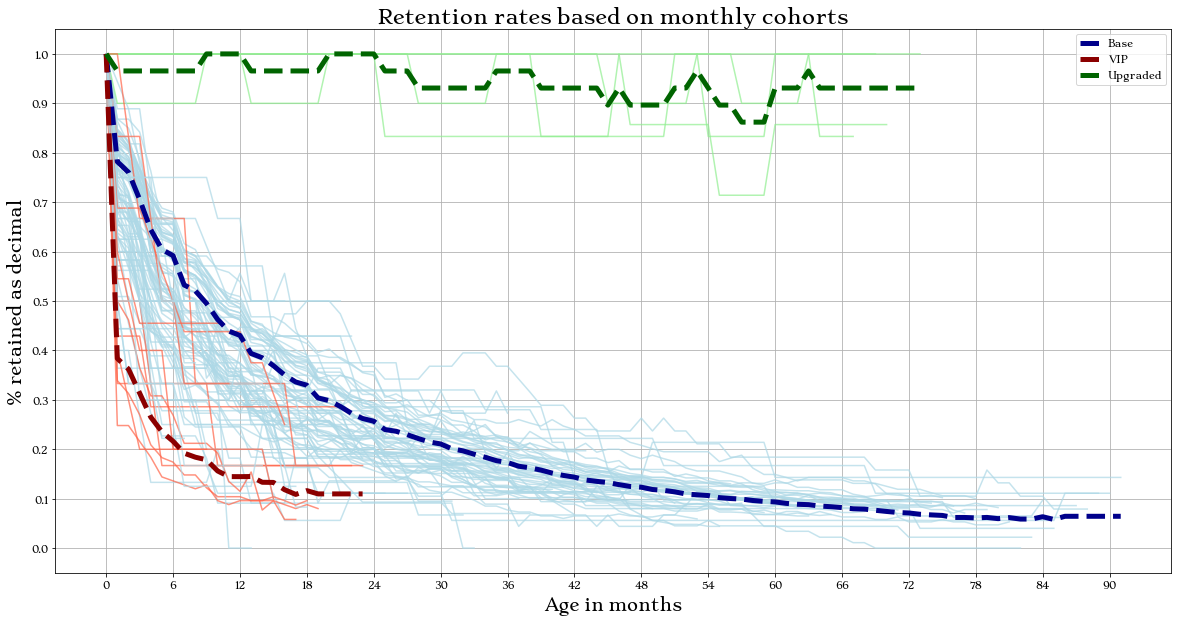

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot()#len(years), 1, ryear)
ax.set_yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
ax.set_xticks([num*6 for num in range((len(base_cohort_retentions)//6)+1)])

#plotting each cohort from each of the 3 types
for c in cohorts:
    try:
        ax.plot(base_cohort_retentions[str(c)], color='lightblue', alpha=0.7) #alpha is transparency
        ax.plot(vip_cohort_retentions[str(c)], color='tomato', alpha=0.7)
        ax.plot(upgraded_cohort_retentions[str(c)], color='lightgreen', alpha=0.7)
        #uncomment following lines to get cohort labels at end of lines - need to add labels in ax.plot above; label=c
        #y = cohort_retentions[str(c)].copy()
        #y.dropna(inplace=True)
        #y=y.tolist()
        #plt.text(len(y)-1, y[-1], str(c), size=15)
    except:
        pass #means the cohort was dropped as it is at tail end

#plotting the mean for each of the 3 types
ax.plot(base_cohort_retentions['mean retention'], label='Base', ls='--', lw=5, color='darkblue')
ax.plot(vip_cohort_retentions['mean retention'], label='VIP', ls='--', lw=5, color='darkred')
ax.plot(upgraded_cohort_retentions['mean retention'], label='Upgraded', ls='--', lw=5, color='darkgreen')

ax.grid()
ax.set_xlabel('Age in months', size=17)
ax.set_ylabel('% retained as decimal', size=17)
ax.set_title("Retention rates based on monthly cohorts", size=20)

ax.legend(loc="upper right")
plt.show()

## Calculating average VIP profitability

A critical KIP is 'how much is the average VIP (or other member) worth in gross profit?'. As with retention, this is best measured using cohorts and is best if expressed in regards to time - 'how much profit after X months'.

We will need to exclude the 0 month in this calculation. The reason for this is that there are many different onboarding options; some may pay full price, some half, some close to 0, and so on. If we did not exclude the 0 (start) month, all the cohort lines would start at different points making it very hard to compare and understand what is going on. Further, since the profit margin at onboarding is defined by discount %, this is best handled during marketing. Recall one of the things we really want to know - how much can we spend to aquire a single user? It is easy to add on gross profit left over after % discount when looking at marketing campaigns.

For example: A digital marketing campaign has a 50% discount, resulting in a £20 gross profit at the moment of checkout. However, that same campaign has an average cost per aquisition (CPA) of £25. With the graph we will create it is very easy to gain insight and evaluate this campaign. On the 0 month, the campaign starts with a negative average profit of £5, and the graph will tell us that we will make up this £5 after only 6 months. By repeating this quick mental calculation over multiple marketing campaigns with different % discounts and CPAs, it is easy to see why it is advantages to zero out the first month!

In regards to investor relations, it also easy to simply add 100% of the gross profit of the first month to all figures.

### Importing data
The format needed is slightly different from how it was prepped before, and some different data sources are also needed

In [19]:
orders2 = pd.read_csv('All-Orders-Clean.csv')
products = pd.read_csv('All-Products-SKUs.csv')
users = pd.read_csv('All-Users-Roles.csv')
subs = pd.read_csv('Subscriptions.csv')
gross_profit = pd.read_csv('line_item_profit.csv')

In [20]:
gross_profit.columns = gross_profit.columns.str.lower()
gross_profit.rename(columns={"thing": "product name"}, inplace=True)
gross_profit.head(2)

,product name,gross profit,gross profit 2
0,VIP Membership - Every 2 months,2.68,4.47
1,VIP Membership - Every 3 months,2.68,4.47


In [21]:
#cleaning up the orders data
orders2.columns = orders2.columns.str.lower()
orders2.rename(columns={"customer user id": "user id"}, inplace=True)

#we only want successful and completed orders
orders2 = orders2.where(orders2['order status']=='wc-completed').reset_index(drop=True)

#keeping only the needed data
#print(orders.columns)
cols_to_keep = ['user id', 'order id', 'order date', 'sku', 'product name', 'quantity']
orders2 = orders2[cols_to_keep]

#convert 'order date' to datetime object
orders2['order date'] = pd.to_datetime(orders2['order date'])

#adding in gross profit
orders2 = orders2.merge(gross_profit, on='product name', how='left')
#gross profit columns yet account for quantity column, doing now
orders2['gross profit'] = orders2['gross profit']*orders2['quantity']
orders2['gross profit 2'] = orders2['gross profit 2']*orders2['quantity']

#Now, postage and handling expense has to be added in for gross profit.
#if only 1 item: pick&pack=£0.33, else 0.50.
#postage=£1.28 and envelope=£0.20; £1.48 added to only the first item of each order
#first will do single item orders
duplicate_order_ids = orders2[orders2.duplicated('order id')]['order id'].unique()
orders2.loc[~orders2['order id'].isin(duplicate_order_ids), 'gross profit 2'] -= (0.33+1.48) #note the ~
#next multi item orders
for oid in duplicate_order_ids:
    holder = orders2.loc[orders2['order id']==oid]
    holder.loc[holder.index[0], 'gross profit 2'] -= (0.50+1.48)
    orders2.loc[orders2['order id']==oid] = holder

#now to rename and drop profit columns, remove NaN, and reset index
orders2.rename(columns={"gross profit 2": "profit"}, inplace=True)
orders2.drop(columns=['gross profit', 'quantity'], axis=1, inplace=True)
orders2.dropna(inplace=True)
orders2.reset_index(inplace=True, drop=True)

orders2.head(2)

,user id,order id,order date,sku,product name,profit
0,1303596,591726,2019-10-01 00:00:03,BCB102,The 5 Bladed Colonel - Every 2 months,4.32
1,1304065,591729,2019-10-01 00:01:02,BCB102,The 5 Bladed Colonel - Every 2 months,4.32


In [22]:
#cleaning product data and only keeping needed columns
products.columns = products.columns.str.lower()
cols = ['title', 'sku', 'price']
products = products[cols]

products.head(2)

,title,sku,price
0,The Five Bladed Colonel,NaN,8.5
1,The Five Bladed Colonel,BSL301294,8.5


In [23]:
#Cleaning user data
users.columns = users.columns.str.lower()
users.rename(columns={"id": "user id"}, inplace=True)

#need to filter down to just VIP users
print(users['user role'].unique())
users = users.where((users['user role']=='vip_customer|customer')|
                    (users['user role']=='vip_customer|subscriber')|
                    (users['user role']=='vip_customer')|
                    (users['user role']=='subscriber|vip_customer')
                   )
users.dropna(inplace=True)
users.reset_index(inplace=True, drop=True)

users['user id'] = users['user id'].astype(int)#for some reason it converts to float in a step above.

users.head(2)

['administrator' 'subscriber' 'customer' 'vip_customer|customer'
 'vip_customer|subscriber' 'vip_customer' 'shop_manager' 'author'
 'vip_customer|administrator']


,user id,user email,user role
0,1283672,chrisbob@ntlworld.com,vip_customer|customer
1,1283707,rosswhittingham@gmail.com,vip_customer|customer


In [24]:
#cleaning subscriber data
subs.columns = subs.columns.str.lower()
subs.rename(columns={"id":"subscription id", 
                     "_customer_user":"user id",
                     "parent":"OG order id"
                    }, 
            inplace=True)

#convert 'order date' to datetime object
subs['date'] = pd.to_datetime(subs['date'])

subs.head(2)

,user id,subscription id,date,title,content,_order_total,_order_tax,_order_currency,OG order id
0,1283448,131097,2014-04-10 14:16:52,"Subscription &ndash; Apr 15, 2016 @ 11:12 PM",NaN,8.5,0.0,GBP,1762
1,1283449,131098,2014-04-10 14:23:32,"Subscription &ndash; Apr 15, 2016 @ 11:12 PM",NaN,8.5,0.0,GBP,1763


### Creating cohorts and calculating

In [25]:
#For each user, we need to find their first 'VIP' purchase,
#this marks their start as a VIP customer, either new or upgraded
#first we will make a df with only order items that are related to VIPs
vip_trigger = orders2.loc[orders2['product name'].str.contains("VIP")]
vip_trigger.reset_index(inplace=True, drop=True)
#sorting by date now will make grabbing users' earliest date easier
vip_trigger.sort_values(by=['order date'], inplace=True, ascending=True) 

#add a column to users to hold first order data (which will be used for cohort assignment)
users['first order'] = np.nan

#for each user we grab their first VIP order date
for u in users['user id'].unique(): #using .unique() just in case.
    holder = vip_trigger.loc[vip_trigger['user id']==u]
    if len(holder)>=1:
        holder.reset_index(drop=True, inplace=True)
        earliest = holder.loc[0, 'order date']#grabbing earliest date item
        users.loc[users['user id']==u, 'first order'] = earliest
    else:
        pass #no orders found, leave first order as NaN and will drop them next.
users.dropna(inplace=True)
users.reset_index(inplace=True, drop=True)

#Creating a column to hold the assigned cohort data
users['cohort'] = np.nan


users.head(2)

,user id,user email,user role,first order,cohort
0,1283672,chrisbob@ntlworld.com,vip_customer|customer,2020-06-24 13:37:05,NaN
1,1283707,rosswhittingham@gmail.com,vip_customer|customer,2021-02-27 12:50:53,NaN


In [27]:
#creating start and end dates for cohort buckets
#each end must be extended by one month, or that month gets clipped in the next step
users['first order'] = pd.to_datetime(users['first order']) 
users['first order'] = users['first order'].dt.date
start = min(users['first order'])-relativedelta(months=1)
end = max(users['first order'])+relativedelta(months=1)

buckets = pd.date_range(start, end, freq='M')
#making bucket labels count down, this makes the label equal to the "age" of the cohort.
bucket_labels = [num for num in range(1, len(buckets))]

print(start)
print(end)
print(buckets[0]) 
print(buckets[1])
print(bucket_labels)


#applying cohort buckets and labels
users['first order'] = pd.to_datetime(users['first order']) #this didn't stay as datetime object for some reason.
users['cohort'] = pd.cut(users['first order'], bins=buckets, labels=bucket_labels)
users['cohort'] = users['cohort'].astype(int)
users.reset_index(inplace=True, drop=True)




users.head(2)

2019-10-19
2022-05-30
2019-10-31 00:00:00
2019-11-30 00:00:00
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


,user id,user email,user role,first order,cohort
0,1283672,chrisbob@ntlworld.com,vip_customer|customer,2020-06-24,8
1,1283707,rosswhittingham@gmail.com,vip_customer|customer,2021-02-27,16


In [28]:
#creating a column that serves as a marker for how many months from "start" the order was made 
#to ensure everything lines up, we'll use the same start date as for cohorts, but make new end and buckets

orders_end = max(orders2['order date'])+relativedelta(months=1)
order_buckets = pd.date_range(start, orders_end, freq='M') #important to use MS (month start) or last day of month orders are NaN
cohort_age_bucket_labels = [num for num in range(1, len(order_buckets))]


print(cohort_age_bucket_labels) 
print(order_buckets[0]) 
print(order_buckets[1])
print(order_buckets[-1])

orders2['age'] = 0
orders2["age"] = pd.cut(orders2['order date'], bins=order_buckets, labels=cohort_age_bucket_labels)
orders2.dropna(inplace=True, axis=0) #NaN are orders before first cohort
orders2.reset_index(drop=True, inplace=True)
orders2['age'] = orders2['age'].astype(int)
print(orders2["age"].unique()) 


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
2019-10-31 00:00:00
2019-11-30 00:00:00
2022-05-31 00:00:00
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


In [29]:
merged = users.merge(orders2, how='left', on='user id')

#there are a couple NaNs, these come from VIPs that have bought no further items, we'll fill those with 0s
#with only 6 of them, it's a good sign for premium handle!
print('number of NaNs by column:')
print(merged.isna().sum())
merged.fillna(value=0, inplace=True)
print('len is:', len(merged))

#'order age' is the age of an order in months since the start of the cohort.
#so an order made in month 9 from a member who is in a cohort 'aged' month six, 
#results in an 'order age of 3'
merged['order age'] = merged['age']-merged['cohort']
print("num of orders made before member was VIP:", len(merged.loc[merged['order age']<0]))
#there are a couple of lines where the order is older than the member is a VIP,
#this isn't what we want to measure, so we will drop those orders.
merged = merged.loc[merged['order age']>= 0]

print('num of unique users: ', len(merged['user id'].unique()))
print('final len is:', len(merged))
merged.head(2)

number of NaNs by column:
user id         0
user email      0
user role       0
first order     0
cohort          0
order id        0
order date      0
sku             0
product name    0
profit          0
age             0
dtype: int64
len is: 3464
num of orders made before member was VIP: 697
num of unique users:  584
final len is: 2767


,user id,user email,user role,first order,cohort,order id,order date,sku,product name,profit,age,order age
0,1283672,chrisbob@ntlworld.com,vip_customer|customer,2020-06-24,8,622598,2020-06-24 13:37:05,BCVIP101,VIP Membership - Each month,2.49,8,0
1,1283672,chrisbob@ntlworld.com,vip_customer|customer,2020-06-24,8,622598,2020-06-24 13:37:05,BCVIPHNDL,Premium Handle,15.00,8,0


In [30]:
"""
Some dummy orders need to be added. this is to avoid a month being dropped
in the next cell during a pivot table. if any order age has no orders then
that column will be dropped. We will simply add in 1 dummy order of 0 pounds
"""


dummy_row = merged.iloc[0]
dummy_row['cohort'] = 1
dummy_row['profit'] = 0.1

max_order_age = max(merged['order age'])+1
for age in range(max_order_age):
    holder_dummy = dummy_row.copy()
    holder_dummy['order age'] = int(age)
    #pd.concat([merged, holder_dummy], ignore_index=True)
    merged = merged.append(holder_dummy, ignore_index=True)
    

In [31]:
merged['order age'].unique()

array([ 0,  1,  2,  5,  8,  9, 10, 11, 12, 13, 14,  4,  6,  3, 15, 16, 18,
       20, 22, 24, 26,  7, 17, 23, 21, 27, 19, 25, 28, 29, 30])

In [32]:
vip_gain_per_month = pd.pivot_table(merged, values=['profit'], index=['cohort'], 
                                    columns=['order age'], aggfunc=np.sum,
                                    fill_value=0 #NaNs result from no purchase in that month from that cohort
                                    )
vip_gain_per_month = vip_gain_per_month.droplevel(level=0, axis=1) #taking out an unneeded level "net"

vip_gain_per_month.head(2)

order age,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
cohort,,,,,,,,,,,,,,,,,,,,,
1,105.41,7.15,8.08,8.08,5.42,2.76,8.08,3.95,0.1,8.08,...,2.76,2.76,2.76,5.42,2.76,2.76,0.1,2.76,2.76,2.76
2,174.93,25.91,2.66,7.98,0.00,0.00,2.66,2.66,0.0,5.32,...,2.66,0.00,2.66,0.00,0.00,2.66,0.0,2.66,2.66,0.00


In [33]:
vip_gain_per_month.reset_index(inplace=True)
vip_gain_per_month.head(2)

order age,cohort,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
0,1,105.41,7.15,8.08,8.08,5.42,2.76,8.08,3.95,0.1,...,2.76,2.76,2.76,5.42,2.76,2.76,0.1,2.76,2.76,2.76
1,2,174.93,25.91,2.66,7.98,0.00,0.00,2.66,2.66,0.0,...,2.66,0.00,2.66,0.00,0.00,2.66,0.0,2.66,2.66,0.00


In [34]:
vip_gain_per_month.columns.name = None
vip_gain_per_month.head(2)

,cohort,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
0,1,105.41,7.15,8.08,8.08,5.42,2.76,8.08,3.95,0.1,...,2.76,2.76,2.76,5.42,2.76,2.76,0.1,2.76,2.76,2.76
1,2,174.93,25.91,2.66,7.98,0.00,0.00,2.66,2.66,0.0,...,2.66,0.00,2.66,0.00,0.00,2.66,0.0,2.66,2.66,0.00


In [35]:
#The above pivot table is neither cumulative nor normalized.
#we need normalized as what we want is the average value/profit of a single VIP after x months.
#this allows to make meaningful comparisons between cohorts; absolute values do not.
#First we will normalize
vip_cohorts = bucket_labels.copy()
#cohort_sizes = [len(merged.loc[merged['cohort'] == c]) for c in cohorts]#bucket_labels are the cohort labels
vip_cohort_sizes = [len(users.loc[users['cohort'] == c]) for c in vip_cohorts]#bucket_labels are the cohort labels
vip_normalized_gain = vip_gain_per_month.copy()
vip_months_from_start = vip_normalized_gain.columns[1:]


for i in range(len(vip_cohorts)):
    size = vip_cohort_sizes[i]
    c = vip_cohorts[i]
    row = vip_normalized_gain.loc[vip_normalized_gain['cohort']==c, vip_months_from_start]/size
    vip_normalized_gain.loc[vip_normalized_gain['cohort']==c, 1:] = row

#columns are months
vip_normalized_gain.head(2)

,cohort,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
0,1,105.41,1.43000,1.6160,1.6160,1.084,0.552,1.6160,0.7900,0.02,...,0.5520,0.552,0.5520,1.084,0.552,0.5520,0.02,0.5520,0.5520,0.552
1,2,174.93,3.23875,0.3325,0.9975,0.000,0.000,0.3325,0.3325,0.00,...,0.3325,0.000,0.3325,0.000,0.000,0.3325,0.00,0.3325,0.3325,0.000


In [36]:
#next we will make it accumulative through time
vip_accumulated_gain = vip_normalized_gain.copy()

#We need to discount the zero month, as there are many onboarding strategies,
#and if we don't it is impossible to compare as cohorts will all start at different points
vip_accumulated_gain.iloc[:, 1] = 0
vip_accumulated_gain.iloc[:, 1]
for m in vip_accumulated_gain.columns[2:]: #skip cohort column, and since accumulating, skip month 0 too
    vip_accumulated_gain.loc[:, m] = vip_accumulated_gain.loc[:, m] + vip_accumulated_gain.loc[:, m-1]


for c in vip_accumulated_gain['cohort'].unique():
    if c==1: #otherwise the first cohort gets fully knocked out
        pass
    else: #filling with NaN after oldest month of a cohort, so graph doesn't have a flatline at end of each cohort
        max_age_adjuster = c-1
        row = vip_accumulated_gain.loc[vip_accumulated_gain['cohort']==c]
        row.iloc[:, -max_age_adjuster:] = np.nan
        vip_accumulated_gain.loc[vip_accumulated_gain['cohort']==c] = row

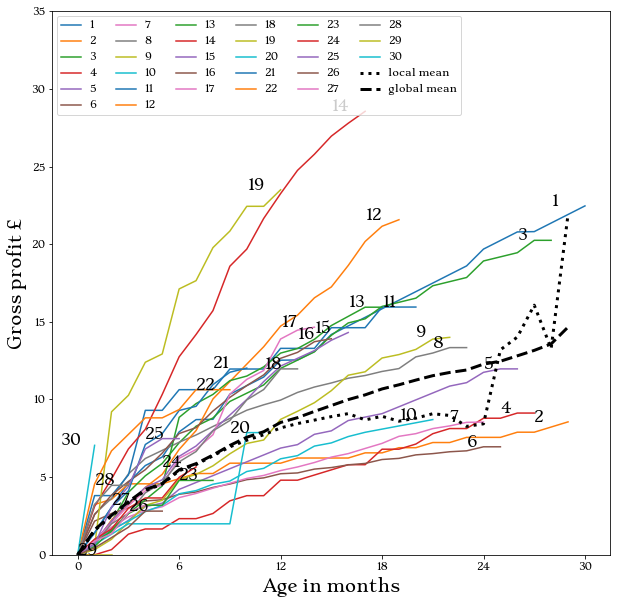

In [40]:
#getting mean of cohorts not taking into account 'younger' cohorts
#when calculating mean of 'older cohorts'
mean_gain_list = []
for col in vip_accumulated_gain.columns:
    if col=="cohort":
        pass
    elif col==0:
        mean_gain_list.append(0)
    else:
        gains = vip_accumulated_gain[col].copy()
        gains.fillna(0, inplace=True)
        gains = list(gains)
        #since we filledna(), we need to not include cohorts that aren't old enough to have sales:
        try:
            w_avg = np.average(gains[:-col], weights=vip_cohort_sizes[:-col])
            mean_gain_list.append(w_avg)
        except:
            mean_gain_list.append(np.nan)
            
#calculating mean, weighted for size of cohorts and 
#'younger' cohort performance will affect performance/mean of 'older' cohorts
vip_mean_gain = vip_gain_per_month.copy() #this is unnormalized and non accumulative version of data
vip_mean_gain[0] = 0 #discounting month zero
#calculating:
mean_normalized_gain = []
for col in vip_mean_gain.columns:
    if col=='cohort':
        pass
    else:
        if col==0:
            mean_normalized_gain.append(0)
        else:
            total = np.sum(vip_mean_gain.loc[:, col])
            user_size = np.sum(vip_cohort_sizes[:-col])
            avg_gain = total/user_size
            mean_normalized_gain.append(avg_gain)
acc_mean_normalized_gain = []
for i in range(len(mean_normalized_gain)):
    if i==0:
        acc_mean_normalized_gain.append(mean_normalized_gain[i])
    else:
        accu = mean_normalized_gain[i]+acc_mean_normalized_gain[i-1]
        acc_mean_normalized_gain.append(accu)




plt.figure(figsize=(10, 10))
biggest_acc_gain = 0 #this is for automatically scaling the y axis.
for c in vip_cohorts:
    try:
        y = vip_accumulated_gain.loc[vip_accumulated_gain['cohort']==c, vip_months_from_start].values[0]
        if max(y) > biggest_acc_gain:#~np.isna(val)
            biggest_acc_gain = max(y)
        x = vip_months_from_start
        plt.plot(x, y, label=c)
        plt.text((max(vip_cohorts)-c-1), max(y), str(c), size=15)
    except:
        pass
#Setting x and y axis ticks
plt.ylim(0,biggest_acc_gain+5)
biggest_acc_gain = int(np.round(biggest_acc_gain, 0))
plt.yticks([num*5 for num in range((biggest_acc_gain//5)+3)]) #making a tick at every £5
plt.xticks([num*6 for num in range((len(vip_normalized_gain)//6)+1)]) #making a tick at every 6 months

y = mean_gain_list
x = vip_months_from_start
plt.plot(x, y, label='local mean', ls=':', lw=3, color='black')

y = acc_mean_normalized_gain
x = vip_months_from_start
plt.plot(x, y, label='global mean', ls='--', lw=3, color='black')
        
plt.xlabel('Age in months', size=17)
plt.ylabel('Gross profit £', size=17)

plt.legend(loc='upper left', ncol=6)
plt.show()

## Predicting of the number of users that will become inactive/cancel 'this' month

This next section will use the cohort data and mean retention curves to create another KPI for the data dashboard - the number of users that will cancel in the current month. To do this, a linear regression model will be fit to each cohort and used to predict future retention. However there are 2 types of cohorts for whom this will not be appropriate: those that are too small (will result in erratic and noisy behavior) and those that are too young (simply aren't enough data points to make a reliable linear model; both cases will be handled by using the respecitve mean retention curve as a stand in.

The feature space is fairly simple: Age (in months) and percentage retained 6 months ago.

An attempt was made to include coupon codes present in the cohort and what % of the cohort each made up. This would have captured wonderfully deep demographic data from facebook - age, sex, profession, interests, prefered OS, and so on. Unfortunately it was discovered that coupon codes were recycled and reused across different digital marketing campaigns, rather than using a dedicated coupon per campaign. This completely washed away the invaluable signal that could have otherwise been captured. Going forward, coupons will be used in a smarter way. As such, I have left the code that would have handled the coupons and transforming them into feature space (via a modified 
bag-of-words approach) so that this can activated in the future. However the models are very accurate already so may not be needed.

In [41]:
"""
First, we'll set a baseline by simply fitting a curve using OLS to 
the cohort retention curves (more or less recreating the mean curve).

Because we're just making a simple regression line, there is no need 
to play with % retained from 6 months previous - something that will
be needed for more complicated ML models further in notebook.
"""

def prep_baseline_data(df):
    X = []
    y = []
    for m in df['month']:
        for c in cohorts:
            if ~np.isnan(df.loc[m, str(c)]):
                X.append(m)
                y.append(df.loc[m, str(c)])
    return np.asarray(X).reshape(-1, 1), y

X_train_base, y_train_base = prep_baseline_data(base_cohort_retentions)

X_train, X_test, y_train, y_test = train_test_split(X_train_base, y_train_base, 
                                                    test_size=0.2, random_state=42
                                                   )

#creating polynomial data
poly = PolynomialFeatures(2)
poly.fit(X_train)
X_train = poly.transform(X_train)
X_test = poly.transform(X_test)

ols = LinearRegression()
ols.fit(X_train, y_train)

preds = ols.predict(X_test)
score = mean_absolute_error(y_test, preds)

print("The score represents percentage points of retention.")
print("So, 0.05 means average error is +/- 5%;")
print("model prediction of 75% can be thought of as 70% to 80%")
print("")
print('test score:', score)

The score represents percentage points of retention.
So, 0.05 means average error is +/- 5%;
model prediction of 75% can be thought of as 70% to 80%

test score: 0.0794335752480665


In [42]:
#creating a bag of words vectorizer for coupon codes
vectorizer = CountVectorizer(min_df=0)#coupon must show up at least 5 times #vocabulary=735 without min_doc_freq
vectorizer.fit(list(orders['coupon'])) #building with full "vocab" of coupons. 
print("vocab size:", len(vectorizer.get_feature_names()))

#we will save each cohort's BoW vector in a dictionary
cohort_coupons = {}
top3_coupons = {}
for c in cohorts:
    holder = base_orders.loc[base_orders['cohort']==c]
    size = len(holder)
    #since CV is looking for sentences and not one off words, we need to combine the column into one big sentence
    #we didn't do it above when creating vocab as it didn't matter for formating (we want one array per cohort)
    #and it allowed us to use min_doc_frequency.
    cohort_corpus = [' '.join(list(holder['coupon']))]
    bow = vectorizer.transform(cohort_corpus)
    cohort_coupons[c] = bow.toarray()[0]/size #normalizing by cohort size
cohort_coupons2 = cohort_coupons.copy()    
#print(vectorizer.get_feature_names())
#print(cohort_coupons[10])

"""
Here I tried some PCA to project the sparse BoW down into a more usable dense vector
for OLS (and also allow for a higher polynomial degree). However, despite 98% and 99% 
explained variance the downstream results were worse (higher poly degrees made even worse)

Once the fact that the signal from coupons was washed out, it is little surprise that
making this "signal" more accessible decreased performance. 

However, the code below should be useful in the future.

#converting dict to matrix for PCA, doing pca, converting back to dict.
matrix = np.array([cohort_coupons[c] for c in cohorts])
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
pca = svd.fit_transform(matrix)
print(pca[0])
print('explained variance:', svd.explained_variance_ratio_.sum())
for c in cohorts:
    cohort_coupons[c] = pca[c-1]#reminder cohorts start at 1 not 0

"""
for c in cohorts:
    cohort_coupons[c] = [0]

#print(vectorizer.get_feature_names())

vocab size: 741


In [43]:
"""
This function transforms the data into features and target, it also seperates out the very 
last month of each cohort for a holdout/validation dataset. the feature vectors are:
[cohort_num, %_retained_6_months_ago, BoW_vector]. 

% retained is set to 6 months previous as the last (most recent) 6 months of a cohort's age are not
reliable given the way retention is calculated. BoW is a sort of one hot encoding for coupons
present in the cohort (divided by cohort size to give % of cohort with any given coupon)
"""

def prep_data(df, bow_dict=cohort_coupons):
    width = len(bow_dict[1])+2#num of 'cols' (2 features + BoW vector length); can't be hard coded as BoW vector may grow
    X = np.empty((0,width), float)#np.array([])
    y = np.empty((0,1), float)
    X_holdout = np.empty((0,width), float)
    y_holdout = np.empty((0,1), float)
    
    #y = []
    for c in cohorts:
        if ~np.isnan(df.loc[0, str(c)]): #checking that the first month isn't NaN (would mean empty cohort)
            for m in df['month']: #month is identical to index and is age
                row = [m]
                if ~np.isnan(df.loc[m, str(c)]): #making sure we aren't predicting too far into future
                    if m >= 6: #grab the retention from 6 months ago
                        row.append(df.loc[m-6, str(c)]) #value of retention 6 months ago
                    else: #padding with 100% retention for first 6 months
                        row.append(1.0)
                    
                    if np.isnan(df.loc[m+1, str(c)]): #checking if it is last month, if so add to holdout
                        row.extend(bow_dict[c]) #adding 'BoW' vector
                        X_holdout = np.vstack([X_holdout, row])
                        #getting target data
                        target = [df.loc[m, str(c)]]
                        y_holdout = np.vstack([y_holdout, target])
                    else: #if not last month, add to train matrix
                        row.extend(bow_dict[c]) #adding 'BoW' vector
                        X = np.vstack([X, row])
                        #getting target data
                        target = [df.loc[m, str(c)]]
                        y = np.vstack([y, target])
    #shuffle data for good practice (though no need to shuffle holdout data)
    shuffler = np.random.permutation(len(X))
    X = X[shuffler]
    y = y[shuffler]
    y = np.ravel(y) #formatting target into one big row.
    y_holdout = np.ravel(y_holdout) #formatting target into one big row.
    return X, y, X_holdout, y_holdout
                    
                

X_train_base, y_train_base, X_holdout_base, y_holdout_base = prep_data(base_cohort_retentions)
X_train_vip, y_train_vip, X_holdout_vip, y_holdout_vip = prep_data(vip_cohort_retentions)



X_train_base

array([[21.   ,  0.273,  0.   ],
       [14.   ,  0.227,  0.   ],
       [31.   ,  0.167,  0.   ],
       ...,
       [36.   ,  0.111,  0.   ],
       [ 3.   ,  1.   ,  0.   ],
       [45.   ,  0.24 ,  0.   ]])

number of degrees: 1
test MAE: 0.04610255474956443
Validation MAE: 0.038796503482818025

number of degrees: 2
test MAE: 0.05072015271677367
Validation MAE: 0.046934166057780786

number of degrees: 3
test MAE: 0.04189391929616085
Validation MAE: 0.041356098324462486

number of degrees: 4
test MAE: 0.03909445190716933
Validation MAE: 0.03768738994049315

number of degrees: 5
test MAE: 0.03671258554970583
Validation MAE: 0.03632714556738695

number of degrees: 6
test MAE: 0.03550383836103035
Validation MAE: 0.035627585336431095

number of degrees: 7
test MAE: 0.03385346485369457
Validation MAE: 0.04084562941655062



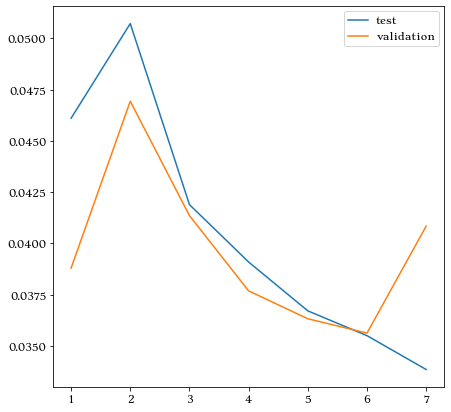

In [44]:
"""
Here we will do a simple "grid search" to find the best hyperparamets.
Since we are just trying the number of degrees for polynomial,
we will use a simple for loop rather than gridsearchCV().
"""
test = []
validation = []
num_degrees = []

for deg in range(1, 8):
    #prepping and splitting data
    X_train_base, y_train_base, X_holdout_base, y_holdout_base = prep_data(base_cohort_retentions)
    X_train_vip, y_train_vip, X_holdout_vip, y_holdout_vip = prep_data(vip_cohort_retentions)
    X_train, X_test, y_train, y_test = train_test_split(X_train_base, y_train_base, 
                                                    test_size=0.2, random_state=42
                                                   )
    #creating polynomial data
    poly = PolynomialFeatures(deg)
    poly.fit(X_train)
    X_train = poly.transform(X_train)
    X_test = poly.transform(X_test)
    #training model
    base_model = LinearRegression()
    base_model.fit(X_train, y_train)
    #making predictions
    preds = base_model.predict(X_test)
    result = mean_absolute_error(y_test, preds)
    #trying on holdout/validation set
    X_test_hold = poly.transform(X_holdout_base)
    holdout_preds = base_model.predict(X_test_hold)
    holdout_result = mean_absolute_error(y_holdout_base, holdout_preds)
    
    test.append(result)
    validation.append(holdout_result)
    num_degrees.append(deg)
    
    print("number of degrees:", deg)
    print("test MAE:", result)
    print("Validation MAE:", holdout_result)
    print("")
    

plt.figure(figsize=(7,7))
plt.plot(num_degrees, test, label='test')
plt.plot(num_degrees, validation, label='validation')
plt.legend(loc='upper right')
plt.show()

In [45]:
"""
Above it seems as though the model begins to overfit after 3 or 4 degrees.
Since there is no meaningful increase in performance with 4 over 3,
we will use 3 in order to keep the models a little lighter.
"""

X_train_base, y_train_base, X_holdout_base, y_holdout_base = prep_data(base_cohort_retentions)
X_train_vip, y_train_vip, X_holdout_vip, y_holdout_vip = prep_data(vip_cohort_retentions)
X_train, X_test, y_train, y_test = train_test_split(X_train_base, y_train_base, 
                                                    test_size=0.2, random_state=42
                                                   )

#creating polynomial data
poly = PolynomialFeatures(3)
poly.fit(X_train)
X_train = poly.transform(X_train)
X_test = poly.transform(X_test)
#training model
base_model = LinearRegression()
base_model.fit(X_train, y_train)
#making predictions
preds = base_model.predict(X_test)
result = mean_absolute_error(y_test, preds)

print(result)

"""
Now lets compare to the hold out data
"""
X_test_hold = poly.transform(X_holdout_base)

holdout_preds = base_model.predict(X_test_hold)
holdout_result = mean_absolute_error(y_holdout_base, holdout_preds)

"""
This looks good! The test set here is a 50% reduction in MAE
and we are on average within +/- 2.8% points on the holdout set!
"""
print(holdout_result)

0.04259331832494642
0.04108078851711345


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_train_vip, y_train_vip, 
                                                    test_size=0.2, random_state=42
                                                   )

#creating polynomial data
vip_poly = PolynomialFeatures(3)
vip_poly.fit(X_train)
X_train = vip_poly.transform(X_train)
X_test = vip_poly.transform(X_test)

#training model
vip_model = LinearRegression()
vip_model.fit(X_train, y_train)

#making predictions
preds = vip_model.predict(X_test)
result = mean_absolute_error(y_test, preds)

"""
0.0274130408126652 with 3 poly
0.1593907687461351 with 4 poly
"""

print(result)

"""
Now lets compare to the hold out data
"""
X_test_hold = vip_poly.transform(X_holdout_vip)

holdout_preds = vip_model.predict(X_test_hold)
holdout_result = mean_absolute_error(y_holdout_vip, holdout_preds)

"""
2 poly
0.09753713112409113
0.10998331513435848

3 poly
0.09793221464602936
0.1045476151105964

4 poly
0.08693050432594847
0.07172157525446231

5 poly
0.0862107492515109
0.1100188676349166
"""

print(holdout_result)

0.1063040020350098
0.08708553563656903


In [47]:
"""
Because of how we define a lapsed/canceled user, we can't know if someone has canceled until 6 months later.
This creates an issue when counting the number of users who cancle 'this' month, as we don't know how many
were active 'last' month. So we will need to use the model to make predictions both for this month and
last month and then take the difference. This does mean the error rate will compound, but we are restricted
by the way we have defined a cancaled user.

The accuracy could be boosted by creating a second model that predicts using retetion from 5 months ago
rather than 6 months ago. However, again, given that this 'KPI' is a vanity metric, I'm just going to
keep things simple and use the same model for both.
"""

base_cohort_sizes = [len(base_orders.loc[base_orders['cohort']==c, 'user id'].unique()) for c in cohorts]
vip_cohort_sizes = [len(vip_orders.loc[vip_orders['cohort']==c, 'user id'].unique()) for c in cohorts]


def get_total_lost(model=base_model, poly=poly, df=base_cohort_retentions, cohorts=cohorts, is_vip='no', prnt='no'):
    #model input: [ 7.   ,  0.781,  0.   ] - age, % 6 months ago, 0
    total_this_month = 0
    total_last_month = 0
    for c in cohorts:
        #prepping features vector
        row_index = len(cohorts)-c-6 #-6 because 6 months ago
        if row_index > 0:
            retained_6_months_ago = df.loc[row_index, str(c)]
            if (row_index-1) > 0:
                retained_7_months_ago = df.loc[row_index-1, str(c)]
            else:
                retained_7_months_ago = 1.0
        else:
            retained_6_months_ago = 1.0
            retained_7_months_ago = 1.0
        age = len(cohorts)-c
        if pd.isna(retained_6_months_ago): #means cohort is too small for consideration and is np.nan
            pass
        else:
            #predicting % retained and converting that to % lost
            features_current = poly.transform(np.asarray([age, retained_6_months_ago, 0]).reshape(1, -1))
            features_last = poly.transform(np.asarray([age-1, retained_7_months_ago, 0]).reshape(1, -1))
            perc_retained_current = model.predict(features_current)[0]
            perc_retained_last = model.predict(features_last)[0]
            if is_vip=='no':
                c_size = base_cohort_sizes[c-1]# -1 because cohorts start at 1 not 0
            else:
                c_size = vip_cohort_sizes[c-1]# -1 because cohorts start at 1 not 0
            num_retained_current = int(np.round(c_size*perc_retained_current,0))
            num_retained_last = int(np.round(c_size*perc_retained_last,0))
            
            if prnt=='yes':
                print(c, row_index)
                print(retained_6_months_ago, retained_7_months_ago)
                print(np.round(perc_retained_current, 4), np.round(perc_retained_last, 4))
                print("")
                
            total_this_month += num_retained_current
            total_last_month += num_retained_last
            
    total_lost = total_last_month - total_this_month
    return total_lost
            
    
    

#print(cohorts)
#print(base_cohort_sizes)
#print(vip_cohort_sizes)


#print("")
base_lost = get_total_lost()
print("number of basic subs that will cancel:", base_lost)
vip_lost = get_total_lost(model=vip_model, poly=vip_poly, df=vip_cohort_retentions, cohorts=cohorts, is_vip='yes')
print("number of VIPs that will cancel:", vip_lost)

number of basic subs that will cancel: -6
number of VIPs that will cancel: 46


# Putting the dashboard together

In [48]:
base_orders.loc[base_orders['user id']==1283452]

,user id,order id,order date,order total,coupon,cohort
2,1283452,1775,2014-04,0.01,swigshave,1.0
85,1283452,2165,2014-07,8.50,none,1.0


In [49]:
"""
One of the dashboard features is being able to click on a cohort line 
and get some stats on that cohort (start data, and top 3 coupons used)
In order to do that, we will store that data as a formated string in
a dictionary for each type.

NOTE: this cell will only apply to retention graph, a bidge for VIPs
must be made as their cohort counts are different in the acc. profit graph
"""

top3_coupons_base = {}
for c in cohorts:
    start_date = 'Date:  '+str(cohort_months[c-1].month)+"/"+str(cohort_months[c-1].year)
    #we need to do a little data manipulation here
    holder = base_orders.loc[base_orders['cohort']==c].copy()
    size = len(holder['user id'].unique())
    holder = holder[holder.coupon != 'none'] #dropping orders with 'none' coupon as it is not useful
    holder['count'] = 1
    holder2 = holder.groupby('coupon', as_index=False)[['count']].sum()
    holder2['count'] = holder2['count']/size #this gives percentage use as a decimil
    holder2.sort_values(by='count', ascending=False, ignore_index=True, inplace=True)
    holder2['count'] = np.round(holder2['count']*100, 2) #converting to % format, will add % in a couple rows
    
    if len(holder2)>=3:
        txtlst = [start_date]
        for i in range(3):
            val = str(holder2.loc[i, 'count'])+"%"
            coup = holder2.loc[i, 'coupon'] +':  '+ val
            txtlst.append(coup)
        txtstr = "\n".join(txtlst) #formats so each date/stat is on a new line
        top3_coupons_base[c] = txtstr
    elif len(holder2)==0:
        top3_coupons_base[c] = start_date
    else:
        txtlst = [start_date]
        for i in range(len(holder2)):
            val = str(holder2.loc[i, 'count'])+"%"
            coup = holder2.loc[i, 'coupon'] +':  '+ val
            txtlst.append(coup)
        txtstr = '\n'.join(txtlst)
        top3_coupons_base[c] = txtstr

#once more for VIPs
top3_coupons_vip = {}
for c in cohorts:
    start_date = 'Date:  '+str(cohort_months[c-1].month)+"/"+str(cohort_months[c-1].year)
    #we need to do a little data manipulation here
    holder = vip_orders.loc[vip_orders['cohort']==c].copy()
    size = len(holder['user id'].unique()) #must be done before dropping none rows
    holder = holder[holder.coupon != 'none'] #dropping orders with 'none' coupon as it is not useful
    holder['count'] = 1
    holder2 = holder.groupby('coupon', as_index=False)[['count']].sum()
    holder2['count'] = holder2['count']/size #this gives percentage use as a decimil
    holder2.sort_values(by='count', ascending=False, ignore_index=True, inplace=True)
    holder2['count'] = np.round(holder2['count']*100, 2) #converting to % format, will add % in a couple rows
    
    if len(holder2)>=3:
        txtlst = [start_date]
        for i in range(3):
            val = str(holder2.loc[i, 'count'])+"%"
            coup = holder2.loc[i, 'coupon'] +':  '+ val
            txtlst.append(coup)
        txtstr = "\n".join(txtlst) #formats so each date/stat is on a new line
        top3_coupons_vip[c] = txtstr
    elif len(holder2)==0:
        top3_coupons_vip[c] = start_date
        #print('no coupons', c)
    else:
        txtlst = [start_date]
        for i in range(len(holder2)):
            val = str(holder2.loc[i, 'count'])+"%"
            coup = holder2.loc[i, 'coupon'] +':  '+ val
            txtlst.append(coup)
        txtstr = '\n'.join(txtlst)
        top3_coupons_vip[c] = txtstr

print(top3_coupons_base[7])

Date:  10/2014
bearded45:  12.0%
regents:  12.0%
abettershave:  8.0%


In [50]:
"""
We will now do the same but for the accumulated
gross profit graph
"""
#first some quick data wrangling
orders3 = merged.copy()
orders3 = orders3.merge(coupons, on='order id', how='left')
orders3.drop('customer user id', inplace=True, axis=1) #is redundant
orders3['coupon'] = orders3['coupon'].fillna('none') #if order didn't have a coupon, then = 'none'
orders3.drop_duplicates(subset="order id", keep='first', inplace=True) #droppinig multiple linne items per order or coupon gets counted for each line item


acc_gain_top3 = {}
for c in vip_cohorts:
    #note, on these timestamps, the start date is actually the very last moment of the prrevious month.
    if order_buckets[c-1].month==12:
        start_month = 1
        start_year = order_buckets[c-1].year+1
    else:
        start_month = order_buckets[c-1].month+1
        start_year = order_buckets[c-1].year  
    start_date = 'Date:  '+str(start_month)+"/"+str(start_year)
    
    #we need to do a little data manipulation here
    holder = orders3.loc[orders3['cohort']==c].copy()
    size = len(holder['user id'].unique()) #must be done before dropping none rows
    holder = holder[holder.coupon != 'none'] #dropping orders with 'none' coupon as it is not useful
    holder['count'] = 1
    holder2 = holder.groupby('coupon', as_index=False)[['count']].sum()
    holder2['count'] = holder2['count']/size #this gives percentage use as a decimil
    holder2.sort_values(by='count', ascending=False, ignore_index=True, inplace=True)
    holder2['count'] = np.round(holder2['count']*100, 2) #converting to % format, will add % in a couple rows
    
    
    if len(holder2)>=3:
        txtlst = [start_date]
        for i in range(3):
            val = str(holder2.loc[i, 'count'])+"%"
            coup = holder2.loc[i, 'coupon'] +':  '+ val
            txtlst.append(coup)
        txtstr = "\n".join(txtlst) #formats so each date/stat is on a new line
        acc_gain_top3[c] = txtstr
    elif len(holder2)==0:
        acc_gain_top3[c] = start_date
        #print('no coupons', c)
    else:
        txtlst = [start_date]
        for i in range(len(holder2)):
            val = str(holder2.loc[i, 'count'])+"%"
            coup = holder2.loc[i, 'coupon'] +':  '+ val
            txtlst.append(coup)
        txtstr = '\n'.join(txtlst)
        acc_gain_top3[c] = txtstr
        
print(acc_gain_top3[5])

Date:  3/2020
jpd34lt:  58.33%


In [51]:
for c in vip_cohorts[0:3]:
    print(acc_gain_top3[c])
    print("")

Date:  11/2019
jpd34lt:  80.0%
g3a8g6b4:  20.0%
j4u58a3y:  20.0%

Date:  12/2019
jpd34lt:  100.0%

Date:  1/2020
jpd34lt:  70.0%
j4u58a3y:  20.0%



In [52]:
#base_cohort_retentions.to_csv('base_cohort_retentions')
#vip_cohort_retentions.to_csv('vip_cohort_retentions')
#upgraded_cohort_retentions.to_csv('upgraded_cohort_retentions')

In [53]:
%matplotlib qt 
#%matplotlib
#%matplotlib inline
#%matplotlib notebook

In [54]:
#def assemble_dash(): #widgets didn't play nice with plot being made in a function
plt.style.use('dark_background')
theme_color = 'darkgray'
second_theme_color = 'lightblue'
plt.set_cmap("tab20c")
fig = plt.figure(constrained_layout=True, figsize=(10,10))
specs = gridspec.GridSpec(ncols=3, nrows=11, figure=fig)

ax1 = fig.add_subplot(specs[0:5, :])#first row
ax2 = fig.add_subplot(specs[6:, 0:2])
ax3 = fig.add_subplot(specs[6:, 2])


"""
Putting the retention data across the entire top
"""
#setting ticks
ax1.set_yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
ax1.set_xticks([num*6 for num in range((len(base_cohort_retentions)//6)+1)])

#plotting each cohort from each of the 3 types
most_recent = len(cohorts)
oldest = 0
cohorts_to_use = cohorts[oldest:most_recent]
#these dictionarys will take the line/artist objects created below as keys, and cohort stats as values
base_lines = {}
vip_lines = {}
for c in cohorts_to_use:
    #base_line = ax1.plot(base_cohort_retentions[str(c)], picker=True, color='lightblue', alpha=0.7) #alpha is transparency
    #base_lines[base_line[0]] = top3_coupons_base[c]
    try:
        base_line = ax1.plot(base_cohort_retentions[str(c)], picker=True, pickradius=2, color='lightblue', alpha=0.7) #alpha is transparency
        base_lines[base_line[0]] = top3_coupons_base[c]
        vip_line = ax1.plot(vip_cohort_retentions[str(c)], picker=True, pickradius=2, color='salmon', alpha=0.7)
        vip_lines[vip_line[0]] = top3_coupons_vip[c]
        #ax1.plot(upgraded_cohort_retentions[str(c)], color='lightgreen', alpha=0.7)
    except:
        pass #means the cohort was dropped as it is at tail end

#plotting the mean for each of the 3 types
ax1.plot(base_cohort_retentions['mean retention'], label='Base', ls='--', lw=5, color='blue')
ax1.plot(vip_cohort_retentions['mean retention'], label='VIP', ls='--', lw=5, color='firebrick')
#ax1.plot(upgraded_cohort_retentions['mean retention'], label='Upgraded', ls='--', lw=5, color='green')

ax1.grid(alpha=0.5, color=theme_color)
ax1.set_xlabel('Age in months', size=17, color=theme_color)
ax1.set_ylabel('% retained as decimal', size=17, color=theme_color)
ax1.set_title("Retention rates based on monthly cohorts", size=17, color=theme_color)
ax1.tick_params(color=theme_color, labelcolor=theme_color)
for spine in ax1.spines.values():
    spine.set_edgecolor(theme_color)

ax1.legend(loc="upper right")


"""
Putting gross profit valuation in second
"""
acc_gain_lines = {} #acc_gain_top3
biggest_acc_gain = 0
for c in vip_cohorts:
    try:
        y = vip_accumulated_gain.loc[vip_accumulated_gain['cohort']==c, vip_months_from_start].values[0]
        if max(y) > biggest_acc_gain:#~np.isna(val)
            biggest_acc_gain = max(y)
        x = vip_months_from_start
        line = ax2.plot(x, y, picker=True, pickradius=3)#, label=c)
        acc_gain_lines[line[0]] = acc_gain_top3[c]
        #ax2.text((max(vip_cohorts)-c-1), max(y), str(c), size=15) #informative but can cause clutter; need to uncomment label above
    except:
        pass

#Setting x and y axis ticks
ax2.set_ylim(0,biggest_acc_gain+5)
biggest_acc_gain = int(np.round(biggest_acc_gain, 0))
ax2.set_yticks([num*5 for num in range((biggest_acc_gain//5)+3)]) #making a tick at every £5
ax2.set_xticks([num*6 for num in range((len(vip_accumulated_gain)//6)+1)]) #making a tick at every 6 months

#plotting mean lines
y = mean_gain_list
x = vip_months_from_start
ax2.plot(x, y, label='local mean', ls=':', lw=4, color='seashell')

y = acc_mean_normalized_gain
x = vip_months_from_start
ax2.plot(x, y, label='global mean', ls='--', lw=4, color='seashell')

ax2.set_xlabel('Age in months', size=17, color=theme_color)
ax2.set_ylabel('Gross profit £', size=17, color=theme_color)
ax2.set_title("Avg. acc. gross profit (excluding onboarding)", size=17, color=theme_color)
ax2.grid(alpha=0.5, color=theme_color)
ax2.tick_params(color=theme_color, labelcolor=theme_color)
for spine in ax2.spines.values():
    spine.set_edgecolor(theme_color)
ax2.legend(loc='upper left')#, ncol=6)


"""
Prediction of number of members lapsing this month goes in ax3
"""
pred_color = second_theme_color
#ax3.grid(alpha=0.5, color=theme_color)#for centering text
ax3.tick_params(color='black', labelcolor='black')
for spine in ax3.spines.values():
    spine.set_edgecolor('black')

#ax3.set_title("This month:", size=20, color=pred_color)
ax3.text(0.5, 0.9, ha='center',#x, y, horizontal alignment
         s='This month:', 
         size=20, color=pred_color
        )
ax3.text(0.5, 0.6, ha='center',#x, y 
         s=str(vip_lost), 
         size=70, color=pred_color
        )
ax3.text(0.5, 0.5, ha='center',#x, y 
         s="VIPs will cancel", 
         size=20, color=pred_color
        )

ax3.text(0.5, 0.15, ha='center',#x, y 
         s=str(base_lost), 
         size=70, color=pred_color
        )
ax3.text(0.5, 0.05, ha='center',#x, y 
         s="Base will cancel", 
         size=20, color=pred_color
        )

"""
Now to build the interactive elements. There are sliders and functions
to update/replot the graphs. Followed by buttons to tell it to replot
"""
#Creating sliders for data selection and other interactive features.
slider_ax = plt.axes([0.15, 0.52, 0.65, 0.01])#position of slider [left, bottom, width, height]
slider = RangeSlider(slider_ax, label='Retention cohorts',
                 valmin=0, valmax=len(cohorts), valstep=1,
                 color=second_theme_color, track_color=theme_color
                )
slider.label.set_color(color=theme_color)
slider.valtext.set_color(color=theme_color)

slider_ax2 = plt.axes([0.15, 0.47, 0.65, 0.01])#position of slider [left, bottom, width, height]
slider2 = RangeSlider(slider_ax2, label='Acc. gain cohorts',
                 valmin=0, valmax=len(vip_cohorts), valstep=1,
                 color=second_theme_color, track_color=theme_color
                )
slider2.label.set_color(color=theme_color)
slider2.valtext.set_color(color=theme_color)



def update_ax1(val):#val = (min, max)
    global base_lines
    global vip_lines
    most_recent = int(slider.val[1]) #this the max val from slider
    oldest = int(slider.val[0]) #this the min val from slider

    cohorts_to_use = cohorts[oldest:most_recent]
    ax1.cla() #clearing old plot
    ax1.set_yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])
    ax1.set_xticks([num*6 for num in range((len(base_cohort_retentions)//6)+1)])
    for c in cohorts_to_use:
        try:#set_ydata
            base_line = ax1.plot(base_cohort_retentions[str(c)], picker=True, pickradius=2, color='lightblue', alpha=0.7) #alpha is transparency
            base_lines[base_line[0]] = top3_coupons_base[c]
            vip_line = ax1.plot(vip_cohort_retentions[str(c)], picker=True, pickradius=2, color='salmon', alpha=0.7)
            vip_lines[vip_line[0]] = top3_coupons_vip[c]
            #ax1.plot(upgraded_cohort_retentions[str(c)], color='lightgreen', alpha=0.7)
        except:
            pass #means the cohort was dropped as it is at tail end

    #plotting the mean for each of the 3 types
    ax1.plot(base_cohort_retentions.loc[:, 'mean retention'], 
             label='Base', ls='--', lw=5, color='blue')
    ax1.plot(vip_cohort_retentions.loc[:, 'mean retention'], 
             label='VIP', ls='--', lw=5, color='firebrick')
    #ax1.plot(upgraded_cohort_retentions.loc[:,'mean retention'], 
    #         label='Upgraded', ls='--', lw=5, color='green')

    ax1.grid(alpha=0.5, color=theme_color)
    ax1.set_xlabel('Age in months', size=17, color=theme_color)
    ax1.set_ylabel('% retained as decimal', size=17, color=theme_color)
    ax1.set_title("Retention rates based on monthly cohorts", size=17, color=theme_color)
    ax1.tick_params(color=theme_color, labelcolor=theme_color)
    for spine in ax1.spines.values():
        spine.set_edgecolor(theme_color)

    ax1.legend(loc="upper right")
    fig.canvas.draw_idle()
    return 'replotted'


def update_ax2(val):
    global acc_gain_lines
    global acc_gain_top3
    most_recent = int(slider2.val[1])
    oldest = int(slider2.val[0])
    cohorts_to_use = vip_cohorts[oldest:most_recent]
    ax2.cla() #clearing old plot
    
    for c in cohorts_to_use:
        try:
            y = vip_accumulated_gain.loc[vip_accumulated_gain['cohort']==c, vip_months_from_start].values[0]
            x = vip_months_from_start
            line = ax2.plot(x, y, picker=True, pickradius=3)#, label=c)
            acc_gain_lines[line[0]] = acc_gain_top3[c]
            #ax2.text((max(vip_cohorts)-c-1), max(y), str(c), size=15) #informative but can cause clutter
        except:
            pass
    #Setting x and y axis ticks but maintaining original biggest_acc_gain so that the plot doesn't "jump"
    #when you update and simply stays at the same scale
    biggest_acc_gain = max(vip_accumulated_gain.iloc[:, 1:])
    ax2.set_ylim(0,biggest_acc_gain+5)
    biggest_acc_gain = int(np.round(biggest_acc_gain, 0))
    ax2.set_yticks([num*5 for num in range((biggest_acc_gain//5)+2)]) #making a tick at every £5
    ax2.set_xticks([num*6 for num in range((len(vip_accumulated_gain)//6)+1)]) #making a tick at every 6 months

    y = mean_gain_list
    x = vip_months_from_start
    ax2.plot(x, y, label='local mean', ls=':', lw=4, color='seashell')

    y = acc_mean_normalized_gain
    x = vip_months_from_start
    ax2.plot(x, y, label='global mean', ls='--', lw=4, color='seashell')

    ax2.set_xlabel('Age in months', size=17, color=theme_color)
    ax2.set_ylabel('Gross profit £', size=17, color=theme_color)
    ax2.set_title("Avg. acc. gross profit (excluding onboarding)", size=17, color=theme_color)
    ax2.grid(alpha=0.5, color=theme_color)
    ax2.tick_params(color=theme_color, labelcolor=theme_color)
    for spine in ax2.spines.values():
        spine.set_edgecolor(theme_color)
    ax2.legend(loc='upper left')#, ncol=6)
    fig.canvas.draw_idle()
    return 'replotted'

"""
Update buttons are also made, this is done to reduce computational
load, especially over remote computer as without it, every 'click'
of movement on slider causes the graph to be reploted. 

If that is not an issue, comment out the coressponding button lines 
and uncomment the slider lines.
"""
#for ax1
#slider.on_changed(update_ax1) #uncomment this to bypass button
ax_button = plt.axes([0.88, 0.51, 0.1, 0.03]) #position of button [left, bottom, width, height]
button = Button(ax_button, label='Replot', color=second_theme_color, hovercolor=theme_color)
button.label.set_color(color='black')
button.on_clicked(update_ax1)
#for ax2
#slider.on_changed(update_ax1) #uncomment this to bypass button
ax_button2 = plt.axes([0.88, 0.46, 0.1, 0.03]) #position of button [left, bottom, width, height]
button2 = Button(ax_button2, label='Replot', color=second_theme_color, hovercolor=theme_color)
button2.label.set_color(color='black')
button2.on_clicked(update_ax2)


#the following function is for selecting a line and getting stats on it
def ax1_select(event):
    global base_lines
    global vip_lines
    ligne = event.artist #this is the selected line
    #getting plotting data for selected line (for 'changing' the color by plotting over)
    x = event.artist.get_data()[0]
    y = event.artist.get_data()[1]
    #getting location of the mouse click
    xloc = event.mouseevent.xdata
    yloc = event.mouseevent.ydata
    
    #updating the plot - clears out any previous selection
    update_ax1(val=None)
    #ploting over the selected line - makes it seem highlighted
    ax1.plot(x, y, color='green', lw=3,)
    #getting the text box
    props = dict(boxstyle='square', facecolor=theme_color, alpha=0.9, 
                 edgecolor='black')
    try:
        textstr = base_lines[ligne]
    except:
        textstr = vip_lines[ligne]
    #ax1.text(xloc, yloc, textstr, color='black', verticalalignment='bottom', bbox=props)
    ax1.text(xloc, 0.9, textstr, color='black', 
             verticalalignment='center', horizontalalignment='left',
             bbox=props)
    return True

#the following function is for selecting a line and getting stats on it
def ax2_select(event):
    global acc_gain_top3
    global acc_gain_lines
    ligne = event.artist #this is the selected line
    #getting plotting data for selected line (for 'changing' the color by plotting over)
    x = event.artist.get_data()[0]
    y = event.artist.get_data()[1]
    #getting location of the mouse click
    xloc = event.mouseevent.xdata
    yloc = event.mouseevent.ydata
    
    #updating the plot - clears out any previous selection
    update_ax2(val=None)
    #ploting over the selected line - makes it seem highlighted
    ax2.plot(x, y, color='green', lw=3,)
    #getting the text box
    props = dict(boxstyle='square', facecolor=theme_color, alpha=0.9, 
                 edgecolor='black')
    textstr = acc_gain_lines[ligne]
    #ax2.text(xloc, yloc, textstr, color='black', verticalalignment='bottom', bbox=props)
    ax2.text(0, biggest_acc_gain, textstr, color='black', 
             verticalalignment='top', horizontalalignment='left',
             bbox=props)
    return True

#figuring out which plot to update
def onpick(event):
    global base_lines
    global vip_lines
    global acc_gain_top3
    global acc_gain_lines
    
    try:
        ligne = event.artist #this is the selected line
        if ligne in acc_gain_lines:
            ax2_select(event)
        else:
            ax1_select(event)
    except:
        pass
    return True
    

fig.canvas.mpl_connect('pick_event', onpick)
    


plt.show()
#return fig
#dash = assemble_dash()
#dash.show()
#plt.show()
#plt.close(fig) #otherwise we get duplicate

In [ ]:
acc_gain_top3.keys()

In [ ]:
if 5 in acc_gain_top3.keys():
    print('good!')